In [1]:
import numpy as np
import time
from tqdm import tqdm

import torch.nn as nn
import torch
import os
import collections


import torchvision
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torchvision.models import vgg19,VGG19_Weights
import torch.nn.functional as F

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt

from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch.utils.data import Dataset, TensorDataset, dataloader, RandomSampler, DataLoader

In [3]:
from source.model import Generator as model_gen

## Discriminator Block

In [6]:
class Discriminator_Conv(nn.Module):

    def __init__(self, channels, normalization, kernel = 3, stride = 2, padding = 1, activation = nn.LeakyReLU(0.2, True), is_bias = False):
        super(Discriminator_Conv, self).__init__()

        # Now initializing all the all variables
        self.channel = channels
        self.kernel = kernel
        self.padding = padding
        self.stride = stride
        self.is_bias = is_bias
        # self.normalization = normalization
        # self.activation = activation

        # now making the conv block

        self.conv_layer = nn.Sequential(
            nn.Conv2d(self.channel, self.channel, self.kernel, self.stride, self.padding, bias = is_bias),
            activation,
            nn.Conv2d(self.channel, self.channel*2, self.kernel, 1, padding = 'same', bias = is_bias),
            normalization,
            activation,
        )
    
    def forward(self,img):
        out_img = self.conv_layer(img)
        return out_img

## Generator Blocks

In [4]:
class ConvNormAct(nn.Module):

    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1, 
                 pad_mode="reflect", groups=1, bias=False, activation = nn.LeakyReLU(0.2,True), 
                 pad_layers = {"zero":nn.ZeroPad2d,"same": nn.ReplicationPad2d,"reflect": nn.ReflectionPad2d,}):

        super(ConvNormAct, self).__init__()

        # getting the activation
        act = activation

        # padding modes
        if pad_mode not in pad_layers:
            raise NotImplementedError(f"Available paddings are : {list(self.pad_layer.keys())}")

        # defining the padding
        padding = pad_layers[pad_mode](padding)

        # defining the conv layer
        self.conv_norm_act_layer = nn.Sequential(
            padding,
            nn.Conv2d(in_ch, out_ch, kernel_size = kernel_size, stride = stride, padding = 0, groups = groups, bias = bias),
            nn.GroupNorm(num_groups=1, num_channels=out_ch, affine=True),
            act,
            )
    
    def forward(self,img):
        return self.conv_norm_act_layer(img)

In [5]:
ConvNormAct(3,  32, kernel_size=7, padding=3)

ConvNormAct(
  (conv_norm_act_layer): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (2): GroupNorm(1, 32, eps=1e-05, affine=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
  )
)

In [6]:
class InvertedResBlock(nn.Module):

    def __init__(self, normalization, in_ch, out_ch, expansion_ratio=2, ):
        super(InvertedResBlock, self).__init__()

        self.use_res_connect = (in_ch == out_ch)
        bottleneck = int(round(in_ch*expansion_ratio))

        # to store the sequence
        self.layers = []

        if expansion_ratio != 1:
            self.layers.append(ConvNormAct(in_ch, bottleneck, kernel_size=1, padding=0))
        
        # dw
        self.layers.append(ConvNormAct(bottleneck, bottleneck, groups=bottleneck, bias=True))
        
        # pw
        self.layers.append(nn.Conv2d(bottleneck, out_ch, kernel_size=1, padding=0, bias=False))

        # adding the normalization
        normalization = nn.GroupNorm(1,num_channels=out_ch, affine=True) if normalization == None else normalization
        
        # appending the normalization
        self.layers.append(normalization)
        
        # making them as a layer
        self.layers = nn.Sequential(*self.layers)

    def forward(self, input):
        
        # # passing through all layers
        # for i,layer in enumerate(self.layers):
        #     input = layer(input)

        output = self.layers(input)

        # resnet adding the input
        if self.use_res_connect:
            output = output + input
        
        return output
        

In [11]:
class Generator(nn.Module):
    def __init__(self,):
        super(Generator, self).__init__()

        self.block_a = nn.Sequential(
            ConvNormAct(3,  32, kernel_size=7, padding=3),
            ConvNormAct(32, 64, stride=2, padding=(0,1,0,1)),
            ConvNormAct(64, 64),
        )
        
        self.block_b = nn.Sequential(
            ConvNormAct(64,  128, stride=2, padding=(0,1,0,1)),            
            ConvNormAct(128, 128),
        )
        
        self.block_c = nn.Sequential(
            ConvNormAct(128, 128),
            InvertedResBlock(normalization = None, in_ch = 128, out_ch = 256, expansion_ratio = 2),
            InvertedResBlock(normalization = None, in_ch = 256, out_ch = 256, expansion_ratio = 2),
            InvertedResBlock(normalization = None, in_ch = 256, out_ch = 256, expansion_ratio = 2),
            InvertedResBlock(normalization = None, in_ch = 256, out_ch = 256, expansion_ratio = 2),
            ConvNormAct(256, 128),
        )    
        
        self.block_d = nn.Sequential(
            ConvNormAct(128, 128),
            ConvNormAct(128, 128)
        )

        self.block_e = nn.Sequential(
            ConvNormAct(128, 64),
            ConvNormAct(64,  64),
            ConvNormAct(64,  32, kernel_size=7, padding=3)
        )

        self.out_layer = nn.Sequential(
            nn.Conv2d(32, 3, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()
        )
        
    def forward(self, input, align_corners=False):

        out = self.block_a(input)
        half_size = out.size()[-2:]
        out = self.block_b(out)

        # passing through the res-block
        out = self.block_c(out)
        
        # upsampling 1
        if align_corners:
            out = F.interpolate(out, half_size, mode="bilinear", align_corners=True)
        else:
            out = F.interpolate(out, scale_factor=2, mode="bilinear", align_corners=False)
        out = self.block_d(out)

        # upsampling 2
        if align_corners:
            out = F.interpolate(out, input.size()[-2:], mode="bilinear", align_corners=True)
        else:
            out = F.interpolate(out, scale_factor=2, mode="bilinear", align_corners=False)
        out = self.block_e(out)

        # final output conv
        out = self.out_layer(out)
        
        return out

## Testing the Generator

In [12]:
# from model import Generator as model_gen

# Initializing the generator
g_model = Generator().to(device)
net = model_gen().to(device)

# printing g_model
g_model

Generator(
  (block_a): Sequential(
    (0): ConvNormAct(
      (conv_norm_act_layer): Sequential(
        (0): ReflectionPad2d((3, 3, 3, 3))
        (1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), bias=False)
        (2): GroupNorm(1, 32, eps=1e-05, affine=True)
        (3): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (1): ConvNormAct(
      (conv_norm_act_layer): Sequential(
        (0): ReflectionPad2d((0, 1, 0, 1))
        (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (2): GroupNorm(1, 64, eps=1e-05, affine=True)
        (3): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (2): ConvNormAct(
      (conv_norm_act_layer): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): GroupNorm(1, 64, eps=1e-05, affine=True)
        (3): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
  )
  (block_b): Sequential(
    (0): ConvNormA

In [9]:
# printing total learnable weights in the model 
# print(f"Total Learnable weights in the Generator model is : {sum([p.numel() for p in g_model.parameters() if p.requires_grad])*1e-6:.3f}M")

# # printing total learnable weights in the model 
# print(f"Total Learnable weights in the net model is : {sum([p.numel() for p in net.parameters() if p.requires_grad])*1e-6:.3f}M")

In [10]:
# for p,name in zip( g_model.parameters(), g_model.state_dict() ):
#     print(p.numel(),'\t- ',p.shape, '\t\t- ', name)

## Testing the model for checking the output

In [36]:
# ### Testing the model by passing a image

# transformations = transforms.Compose([
#     transforms.Resize((256,256)),
#     transforms.ToTensor(),
#     ])

# img = transformations( Image.open('../../All Content Image/animals/b-1.jpg').convert('RGB') )
# print(f"Shape of the image is : {img.shape}")

# # g_model oot
# out_img = g_model(img.unsqueeze(0).to(device)).squeeze(0)
# print(f"Shape of the output image of g_model is : {out_img.shape}")

# # net_model out
# out_img = net(img.unsqueeze(0).to(device)).squeeze(0)
# print(f"Shape of the output image of net_model is : {out_img.shape}")

# # out_img = transforms.ToPILImage()(out_img)
# # plt.imshow(out_img)

Shape of the image is : torch.Size([3, 256, 256])
Shape of the output image of g_model is : torch.Size([3, 256, 256])
Shape of the output image of net_model is : torch.Size([3, 256, 256])


### testing with pre trained weights

In [13]:
anime_generator_weights = torch.load('../animegan2-pytorch/weights/face_paint_512_v2.pt', map_location=device)
updated_anime_generator_weights = collections.OrderedDict()

# updating a new order dict to get the weights
for i,j,z in zip(anime_generator_weights.items(), g_model.parameters(), g_model.state_dict()):
    # print(i,v.shape)
    if  (i[1].shape ==  j.shape ) == False:
        print( i[1].shape, j.shape, i[0] )
        pass
    else:
        updated_anime_generator_weights[z] = i[1].clone()

# now transferring the weights to g_model
# g_model.load_state_dict(torch.load('./weights/ppaprika_new.pt', map_location=device), strict = False)
g_model.load_state_dict(updated_anime_generator_weights, strict = False)

<All keys matched successfully>

In [14]:
net.load_state_dict(anime_generator_weights, strict = False)

<All keys matched successfully>

In [15]:
from torchvision.transforms.functional import to_tensor, to_pil_image

In [15]:
# for i,j in zip(g_model.parameters(), net.parameters()):
#     if i.equal(j) == False:
#         print(i.shape,j.shape)
#         print(i[0][0],'\n\n')
#         print(j[0][0])
#         break

In [16]:
torch.save(g_model.state_dict(), './weights/face_paint_v2.pt')

In [30]:
### Testing the model by passing a image

size = (256,256)

transformations = transforms.Compose([
    transforms.Resize((256,256)),
    ])

img = transformations( Image.open('../animegan2-pytorch/samples/inputs/wednesday-thinking.jfif').convert('RGB') )
# img = Image.open('../animegan2-pytorch/samples/inputs/actor 1.jpg').convert('RGB').resize(size)
img = to_tensor(img) * 2 - 1

# print(img.max(), img.min())

print(f"Shape of the image is : {img.shape}")

Shape of the image is : torch.Size([3, 256, 256])


tensor(0.9512, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.0146, device='cuda:0', grad_fn=<MinBackward1>)
Shape of the output image is : torch.Size([3, 256, 256])


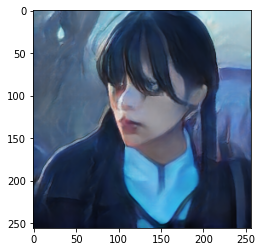

In [32]:
out_img = g_model.eval()( img.unsqueeze(0).to(device) ).squeeze(0)

# clipping the output image
out_img = out_img.clip(-1, 1)*0.5 + 0.5
print(out_img.max(), out_img.min())

print(f"Shape of the output image is : {out_img.shape}")

out_img = transforms.ToPILImage()(out_img)
# out_img = transforms.functional.to_pil_image(out_img)
plt.imshow(out_img)

Shape of the image is : torch.Size([3, 256, 256])
tensor(0.8838, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.0047, device='cuda:0', grad_fn=<MinBackward1>)
Shape of the output image is : torch.Size([3, 256, 256])


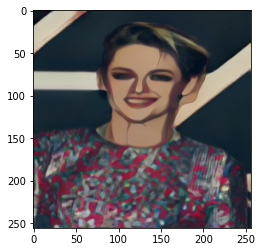

In [44]:
## output from net

"""print(f"Shape of the image is : {img.shape}")
out_img = net.eval()( img.unsqueeze(0).to(device) ).squeeze(0)

# clipping the output image
out_img = out_img.clip(-1, 1)*0.5 + 0.5
print(out_img.max(), out_img.min())

print(f"Shape of the output image is : {out_img.shape}")

out_img = transforms.ToPILImage()(out_img)
# out_img = transforms.functional.to_pil_image(out_img)
plt.imshow(out_img)"""

### testing two models

In [1]:
# torch.save(g_model.state_dict(), './weights/paprika_new.pt')

"""g_model_out = g_model.eval()( img.unsqueeze(0).to(device) )
net_out = net.eval()( img.unsqueeze(0).to(device) )"""

'g_model_out = g_model.eval()( img.unsqueeze(0).to(device) )\nnet_out = net.eval()( img.unsqueeze(0).to(device) )'